<a href="https://colab.research.google.com/github/hufsaim/T10402201/blob/master/ch04/predicting_house_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils import data
import random
import matplotlib.pyplot as plt

# Data Preparation

In [2]:
path0 = '/content/drive/MyDrive/tmp/ch4/'

train_data = pd.read_csv(path0+'kaggle_house_pred_train.csv')
test_data = pd.read_csv(path0+'kaggle_house_pred_test.csv')

In [3]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [4]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [5]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features.shape

(2919, 79)

In [6]:
all_features.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 79, dtype: object

In [7]:
# If test data were inaccessible, mean and standard deviation could be
# calculated from training data
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# After standardizing the data all means vanish, hence we can set missing
# values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [8]:
# `Dummy_na=True` considers "na" (missing value) as a valid feature value, and
# creates an indicator feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [9]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,
                              dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values,
                             dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1),
                            dtype=torch.float32)

# Model & Hyperparameters

In [10]:
loss = nn.MSELoss()
in_features = train_features.shape[1]
def get_net():
    net = nn.Sequential(
        nn.Linear(in_features, 256),
        #nn.ReLU(),
        #nn.Dropout(),
        nn.Linear(256, 512),
        #nn.Dropout,
        #nn.ReLU(),
        nn.Linear(512,1)
    )
    return net

In [11]:
def log_rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [12]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [13]:
k=5
train_features_fold,train_labels_fold,valid_features_fold,valid_labels_fold = get_k_fold_data(k, 0, train_features, train_labels)
print(train_features_fold.shape)
print(train_labels_fold.shape)
print(valid_features_fold.shape)
print(valid_labels_fold.shape)

torch.Size([1168, 331])
torch.Size([1168, 1])
torch.Size([292, 331])
torch.Size([292, 1])


train log rmse: 0.501310
valid log rmse: 0.681237


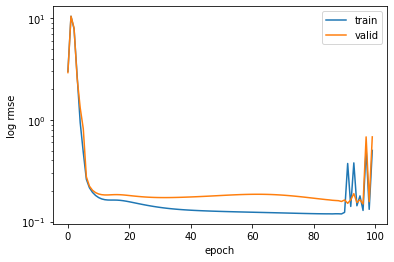

label vs prediction (valid set)


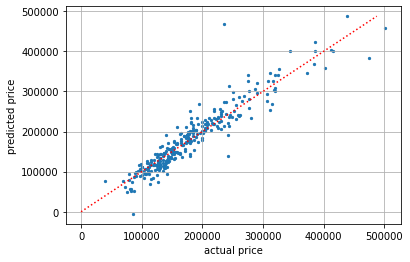

In [14]:
learning_rate = 1.5
weight_decay = 0
batch_size = 64
num_epochs = 100

net0 = nn.Sequential(
        nn.Linear(in_features, 256),
        #nn.ReLU(),
        #nn.Dropout(),
        nn.Linear(256, 512),
        #nn.Dropout,
        #nn.ReLU(),
        nn.Linear(512,1)
    )
  
train_ls, valid_ls = [], []
train_iter = data.DataLoader(data.TensorDataset(train_features_fold,train_labels_fold),batch_size)
optimizer = torch.optim.Adam(net0.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)
for epoch in range(num_epochs):
    for X, y in train_iter:
        optimizer.zero_grad()        
        l = loss(net0(X), y)
        l.backward()
        optimizer.step()
    train_ls.append(log_rmse(net0, train_features_fold, train_labels_fold))      
    valid_ls.append(log_rmse(net0, valid_features_fold, valid_labels_fold))

print(f'train log rmse: {float(train_ls[-1]):f}')
print(f'valid log rmse: {float(valid_ls[-1]):f}')

plt.plot(np.arange(0,num_epochs),train_ls,label='train')
plt.plot(np.arange(0,num_epochs),valid_ls,label='valid')
plt.yscale("log")
plt.xlabel('epoch')
plt.ylabel('log rmse')
plt.legend()
plt.show()

print('label vs prediction (valid set)')
valid_predicted_fold = net0(valid_features_fold).detach().numpy()
pred_max = np.max(valid_predicted_fold)
plt.scatter(valid_labels_fold,valid_predicted_fold,5)
plt.plot(np.arange(0,pred_max),np.arange(0,pred_max),'r:')
plt.grid()
plt.xlabel('actual price')
plt.ylabel('predicted price')
plt.show()

# K-FOLD CROSS VALIDATION for Model Selection

In [15]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [16]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [17]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        plt.plot(np.arange(0,num_epochs),train_ls,label='train')
        plt.plot(np.arange(0,num_epochs),valid_ls,label='valid')
        plt.yscale("log")
        plt.xlabel('epoch')
        plt.ylabel('rmse')
        plt.legend()
        plt.title('fold: '+ str(i))
        plt.show()
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

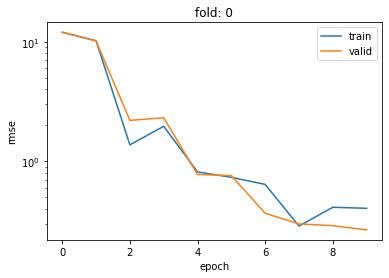

fold 1, train log rmse 0.404783, valid log rmse 0.266913


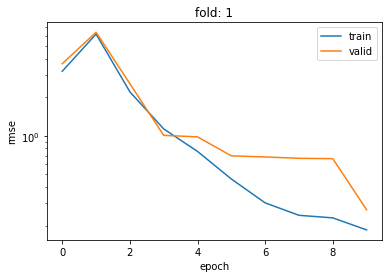

fold 2, train log rmse 0.184786, valid log rmse 0.265386


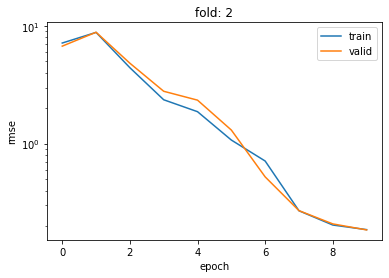

fold 3, train log rmse 0.186044, valid log rmse 0.185000


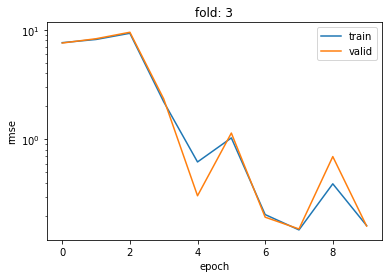

fold 4, train log rmse 0.162838, valid log rmse 0.161276


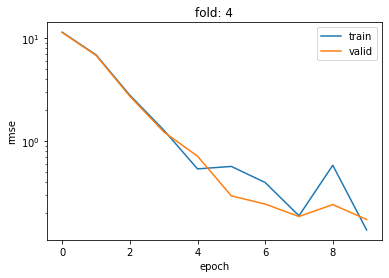

fold 5, train log rmse 0.138276, valid log rmse 0.174367
5-fold validation: avg train log rmse: 0.215346, avg valid log rmse: 0.210588


In [18]:
k, num_epochs, lr, weight_decay, batch_size = 5, 10, 1, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

# Train and Predict
- Train with the determined hyperparameters (using all training examples)
- Export test results to csv file

In [19]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    plt.plot(np.arange(1, num_epochs + 1), train_ls)
    plt.yscale("log")
    plt.xlabel('epoch')
    plt.ylabel('train log rmse')
    plt.show()
    print(f'train log rmse {float(train_ls[-1]):f}')
    # Apply the network to the test set
    preds = net(test_features).detach().numpy()
    # Reformat it to export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv(path0+'submission.csv', index=False)

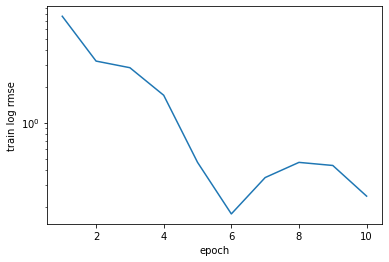

train log rmse 0.244372


In [20]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)